# Multi-indexing

## Basic multi-index concept

Up to here, we've been working under the assumption that our data is two dimensional. That's why it fits so well in a tabular form, and would do quite well in a simple spreadsheet.

Let's change that! 

In [35]:
import pandas as pd 
from datetime import datetime
%matplotlib inline 
from matplotlib import pyplot as plt 
plt.rcParams['figure.figsize'] = [16, 4]

Let's take a toy dataset, with some supermarket foods:

In [36]:
food = pd.read_csv('data/food.csv')
food.head()

,Store,Product,Price,Quality
0,Incontinente,Apples,3.0,2.0
1,Incontinente,Bananas,2.0,4.0
2,Incontinente,Rice,1.0,3.0
3,Incontinente,Olives,4.0,2.0
4,Dingo Poce,Apples,2.0,2.0


Let's think about indexes. So far, we had, for each row, some unique ID. But in the above case, we have several supermarkets and several products. 

In this case, our prices and quality depend on the **Store** AND on the **Product**. So our index needs to contain both:

In [37]:
food = food.set_index(['Store', 'Product'])
food = food.sort_index()

food

Price  Quality
Store        Product                 
Dingo Poce   Apples      2.0      2.0
             Bananas     3.0      3.0
             Dog food    7.0      1.0
             Rice        1.0      4.0
Dumbo        Apples      2.0      3.0
             Dog food    1.0      2.0
             Rice        5.0      4.0
Incontinente Apples      3.0      2.0
             Bananas     2.0      4.0
             Olives      4.0      2.0
             Rice        1.0      3.0

Multi-indexes are crazy useful, especially when the datasets get bigger. They allow us to go into higher dimentions than two dimentions, and keep the intuitive "tabular" structure. 



Let's learn how to select from this! 

## Selecting in multi-indexes

We need an additional tool to perform selection with multi_indexes, which is `pd.IndexSlice`


In [38]:
idx = pd.IndexSlice  # <---- convention, get ready to copy paste this a lot 

### loc

Remember loc? Loc is awesome :) 

Remember, loc allows you to select by doing `data.loc[index, columns]`

Now that we have multiple index levels, we will have to use it a bit more explicitly. 

In [39]:
food

Price  Quality
Store        Product                 
Dingo Poce   Apples      2.0      2.0
             Bananas     3.0      3.0
             Dog food    7.0      1.0
             Rice        1.0      4.0
Dumbo        Apples      2.0      3.0
             Dog food    1.0      2.0
             Rice        5.0      4.0
Incontinente Apples      3.0      2.0
             Bananas     2.0      4.0
             Olives      4.0      2.0
             Rice        1.0      3.0

Let's say we wanted to get the price of Apples, at Dingo Poce. 

If this were just a 1 level index, we would just say `data.loc[rows, columns]`. <br>
However, we have two levels of index. So now we would say: <br> `data.loc[idx[first_index_level, second_index_level], columns]`.

In [10]:
food.loc[idx[: , 'Apples'], 'Price']

Store         Product
Dingo Poce    Apples     2.0
Dumbo         Apples     2.0
Incontinente  Apples     3.0
Name: Price, dtype: float64

Let's answer another question: _What are all the prices at Dingo Poce?_

In [11]:
# from food, 
# A) get the slice of the index 
# B) where the index_level_0 is 'Dingo Poce', 
# C) and everything on the second level (:)
# D) also, give me all the columns (:)

# food.loc[A[B, C], D]
food.loc[idx['Dingo Poce', :], :]

Price  Quality
Store      Product                 
Dingo Poce Apples      2.0      2.0
           Bananas     3.0      3.0
           Dog food    7.0      1.0
           Rice        1.0      4.0

What if you want the apples from all stores?

In [12]:
# from food, 
# A) get the slice of the index 
# B) where we want everything from the first level of the index 
# C) and only the apples from the second level of the index 
# D) again, all of the columns 

# food.loc[A[B, C], D]
food.loc[idx[:, 'Apples'], :]

# idx is love. idx is life. 

,,Price,Quality
Store,Product,,
Dingo Poce,Apples,2.0,2.0
Dumbo,Apples,2.0,3.0
Incontinente,Apples,3.0,2.0


That works! Let's do a few more, for practice: 

##### _"The apples at Dingo Poce"_

In [13]:
food.loc[idx['Dingo Poce', 'Apples'], :]

Price      2.0
Quality    2.0
Name: (Dingo Poce, Apples), dtype: float64

##### _"The price of Bananas, at any store"_

In [14]:
food.loc[idx[:, 'Bananas'], 'Price']

Store         Product
Dingo Poce    Bananas    3.0
Incontinente  Bananas    2.0
Name: Price, dtype: float64

##### _"The quality of Olives, at Incontinente"_

In [15]:
food.loc[idx['Incontinente', 'Olives'], 'Quality']

2.0

##### _"The quality of Rice and Bananas, at Incontinente"_

In [16]:
# notice that we can pass a list to the second half of the index slice
food.loc[idx['Incontinente', ['Bananas', 'Rice']], 'Quality']

Store         Product
Incontinente  Bananas    4.0
              Rice       3.0
Name: Quality, dtype: float64

---- 

### Slicing in multi-indexes 

Sometimes instead of listing the values we want, we might want to take slices. 

Here it will be by alphabetical order (to keep the example simple), but we will see how powerful this is later when we bring in the timeseries. 

From a syntax point of view, slicing means passing `start: end` to our `.loc`, instead of explicitly naming every entry. 

Let's get the quality of the products "from bananas to rice" in Incontinente (from "b" to "r"). This would be problematic if the dataset were not sorted. 

In [17]:
# Notice the nomenclature "start: end" 
food.loc[idx['Incontinente', 'Bananas': 'Rice'], 'Quality']

Store         Product
Incontinente  Bananas    4.0
              Olives     2.0
              Rice       3.0
Name: Quality, dtype: float64

### Groupby (group-apply-combine) in multi-indexes

Let's say we want to know the lowest prices at which we can get each product.  

In the case of this tiny dataset, we can just look directly at the data, or select each product at the time and then take the `.min`, but we will use this very simply question to illustrate a powerful concept. 

In [40]:
food

Price  Quality
Store        Product                 
Dingo Poce   Apples      2.0      2.0
             Bananas     3.0      3.0
             Dog food    7.0      1.0
             Rice        1.0      4.0
Dumbo        Apples      2.0      3.0
             Dog food    1.0      2.0
             Rice        5.0      4.0
Incontinente Apples      3.0      2.0
             Bananas     2.0      4.0
             Olives      4.0      2.0
             Rice        1.0      3.0

In [28]:
food.groupby(level='Product').Price.min()

Product
Apples      2.0
Bananas     2.0
Dog food    1.0
Olives      4.0
Rice        1.0
Name: Price, dtype: float64

Eh... that's cool, but a better questions is _"Where should I buy each product, and how much will it cost there?"_

In [19]:
apples_data = food.loc[idx[:, 'Apples'], :]
apples_data.loc[apples_data.Price == apples_data.Price.min()]

,,Price,Quality
Store,Product,,
Dingo Poce,Apples,2.0,2.0
Dumbo,Apples,2.0,3.0


Where is each product cheaper?

In [20]:
food.groupby(level='Product').Price.idxmin()

Product
Apples         (Dingo Poce, Apples)
Bananas     (Incontinente, Bananas)
Dog food          (Dumbo, Dog food)
Olives       (Incontinente, Olives)
Rice             (Dingo Poce, Rice)
Name: Price, dtype: object

So we found out where the food is cheapest. But now I'm worried about the quality... 

We already know where things are cheaper, let's call it `where_stuff_is_cheapest`

In [21]:
where_stuff_is_cheapest = food.groupby(level='Product').Price.idxmin()

In [27]:
where_stuff_is_cheapest.head(2)

Product
Apples        (Dingo Poce, Apples)
Bananas    (Incontinente, Bananas)
Name: Price, dtype: object

Now we can use this to select. Notice we don't need `idx`, because our index is already a tuple. 

In [28]:
# food, where the indexes of the minimum prices are, with the columns Quality and Price 
food.loc[where_stuff_is_cheapest, ['Quality', 'Price']]

,,Quality,Price
Store,Product,,
Dingo Poce,Apples,2.0,2.0
Incontinente,Bananas,4.0,2.0
Dumbo,Dog food,2.0,1.0
Incontinente,Olives,2.0,4.0
Dingo Poce,Rice,4.0,1.0


So... the minimum price, but only where the quality is higher than 3? 

In [41]:
# Sigh.... ok, so food where the quality is at least 3...
at_least_3_quality_food = food.loc[food.Quality >=3]

# get the indexes where the lowest price occurs 
index_where_lowest_price = at_least_3_quality_food.groupby(level='Product').Price.idxmin()

# now from the food where the quality is at least 3, 
# get the indexes where the price is minimum, 
# and show both quality and price
at_least_3_quality_food.loc[index_where_lowest_price, ['Quality', 'Price']]

,,Quality,Price
Store,Product,,
Dumbo,Apples,3.0,2.0
Incontinente,Bananas,4.0,2.0
Dingo Poce,Rice,4.0,1.0


It's so beautiful! 

## Bring in the timeseries! 

Ok, so that was a basic idea of multi-indexing. But that's not what you are here for, you are here for timeseries!

Let's get back to business! 

Let's take all of the stocks from an exchange between 2007 and 2011

In [42]:
data = pd.read_csv('data/stocks.csv')

In [43]:
data.head()

,Date,Stock,Open,High,Low,Close,Volume
0,2007-01-03,nhc,46.2710,46.4810,45.5640,46.2710,26244
1,2007-01-03,vhi,3.0205,3.0205,2.8661,2.9215,94069
2,2007-01-03,bpt,37.5560,37.5560,37.0750,37.1820,489258
3,2007-01-03,cet,12.4790,12.4960,12.4060,12.4250,36413
4,2007-01-03,lndc,10.7000,11.3700,10.5000,11.3400,245349


How much data do we have? 

In [37]:
data.shape

(475041, 7)

Cool, and we already know how to fix datetimes: 

In [44]:
data['Date'] = pd.to_datetime(data['Date'])

Now, consider this sentence carefully: 

> _**For each stock, for each date**, we have an Open, High, Low, Close, and Volume_

Which means that we have a multi-index, with both date, and stock! 

In [45]:
data = data.set_index(['Date', 'Stock'])
data.head()

Open     High      Low    Close  Volume
Date       Stock                                            
2007-01-03 nhc    46.2710  46.4810  45.5640  46.2710   26244
           vhi     3.0205   3.0205   2.8661   2.9215   94069
           bpt    37.5560  37.5560  37.0750  37.1820  489258
           cet    12.4790  12.4960  12.4060  12.4250   36413
           lndc   10.7000  11.3700  10.5000  11.3400  245349

As mentioned before, we must sort our index:

In [46]:
data = data.sort_index()
data.head()

Open      High       Low     Close   Volume
Date       Stock                                                 
2007-01-03 aap      35.139    35.621    34.527    35.011   776642
           abb      13.422    13.429    13.105    13.192  4030670
           achn     16.430    17.280    16.060    17.280    55226
           achv   1227.600  1231.560  1158.300  1191.960      785
           adm      27.457    27.864    27.065    27.269  8670704

##### Select Microsoft (msft):

In [47]:
data.loc[idx[:, 'msft'], :].head()

,,Open,High,Low,Close,Volume
Date,Stock,,,,,
2007-01-03,msft,25.073,25.367,24.655,25.041,91732862
2007-01-04,msft,24.898,25.132,24.688,24.998,54581739
2007-01-05,msft,24.832,24.948,24.697,24.856,53189559
2007-01-08,msft,24.864,25.242,24.764,25.099,59801289
2007-01-09,msft,25.141,25.308,24.930,25.123,53215396


##### Select all stocks from May  20th, 2009 

In [48]:
data.loc[idx['May 20th, 2009', :], :].head(10)

Open     High      Low    Close   Volume
Date       Stock                                             
2009-05-20 aap     43.258   43.327   41.790   42.203  3000018
           abb     12.090   12.344   12.051   12.076  5429434
           achn     1.530    1.530    1.400    1.460    20597
           achv   154.990  157.960  141.130  151.800    34405
           adm     22.098   22.949   22.021   22.557  9876717
           adsk    19.480   19.880   19.000   19.140  3886829
           ae      14.057   14.057   13.561   13.854     5924
           aehr     1.010    1.040    1.000    1.010    81591
           aeo     10.449   10.991   10.177   10.228  6613587
           aezs   804.000  828.000  798.000  798.000       44

##### Select the Close price of Microsoft, IBM and Ebay, between June 10th and June 14th, 2008?

In [49]:
close_prices_tech_3 = data.loc[idx['June 10th, 2008':'June 14th, 2008', ['msft', 'ibm' ,'ebay']], 'Close']

close_prices_tech_3

Date        Stock
2008-06-10  ebay      12.197
            ibm      105.170
            msft      23.389
2008-06-11  ebay      11.667
            ibm      102.920
            msft      22.744
2008-06-12  ebay      11.818
            ibm      103.420
            msft      23.682
2008-06-13  ebay      11.944
            ibm      105.350
            msft      24.377
Name: Close, dtype: float64

Remember that if you're going to be indexing a certain interval several times it's probably better to create a python slice:

In [50]:
interval = slice('June 10th, 2008','June 14th, 2008')
data.loc[idx[interval, ['msft', 'ibm' ,'ebay']], 'Close']

Date        Stock
2008-06-10  ebay      12.197
            ibm      105.170
            msft      23.389
2008-06-11  ebay      11.667
            ibm      102.920
            msft      22.744
2008-06-12  ebay      11.818
            ibm      103.420
            msft      23.682
2008-06-13  ebay      11.944
            ibm      105.350
            msft      24.377
Name: Close, dtype: float64

#### Working with the index directly 

For fun, we can also ask questions such as: 
> _"What was the average price of stocks on Mondays?"_ 

For this we will use a boolean mask, and a new method, [get_level_values](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjTisXGrOjaAhXHzRQKHSfJCq8QFggpMAA&url=https%3A%2F%2Fpandas.pydata.org%2Fpandas-docs%2Fstable%2Fgenerated%2Fpandas.Index.get_level_values.html&usg=AOvVaw3XDga7SdrZkID3lvOtiaDz)

In [56]:
# Make a boolean mask, as to whether the day is Monday. 
# Notice two things: 
# 1. the use of get_level_values(0), to get the index at the dates level
# 2. the use of .weekday_name directly on the index (no need for .dt)
is_monday = data.index.get_level_values(0).day_name() == 'Monday'

# Now use that boolean mask to get the data for Mondays, then get the mean close price
mondays_data = data.loc[is_monday].Close.mean()

print('Mean Monday price: %0.2f' % mondays_data)

Mean Monday price: 49.90


## Plotting 

##### Plot the close prices for Microsoft:

Using the previous approach, let's try to make a plot:

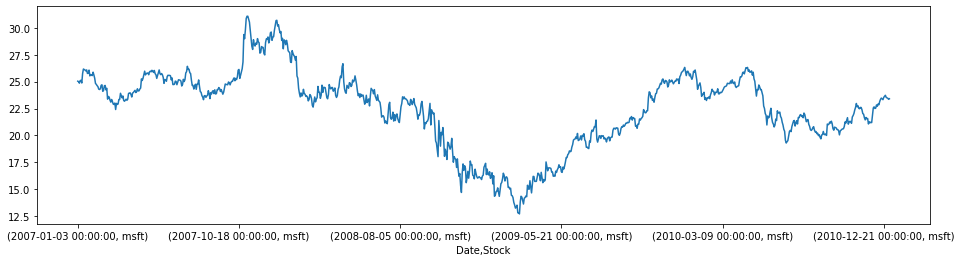

In [47]:
data.loc[idx[:, 'msft'], 'Close'].plot()

## Groupby, and operations 

After this detour, let's get back to our main dataset: 

In [54]:
data.head(3)

Open    High     Low   Close   Volume
Date       Stock                                         
2007-01-03 aap    35.139  35.621  34.527  35.011   776642
           abb    13.422  13.429  13.105  13.192  4030670
           achn   16.430  17.280  16.060  17.280    55226

**What's the right way to do this?** _(well, the chapter IS called Groupby...)_

In [57]:
# group by the stock, and then take the Close, and calculate percentage change 
data.groupby(level='Stock').Close.pct_change().head()

Date        Stock
2007-01-03  aap     NaN
            abb     NaN
            achn    NaN
            achv    NaN
            adm     NaN
Name: Close, dtype: float64

Wait what? Oh, right. On the first day, there isn't a previous day to calculate change. Let's take a look at another day: 

In [58]:
# exceptionally I'm using the "lazy" way to do loc here, for the sake of simplicity:

data.groupby(level='Stock').Close.pct_change().loc['May 5th 2008'].head()

Date        Stock
2008-05-05  aap     -0.018962
            abb      0.004548
            achn     0.045946
            achv     0.020468
            adm      0.003425
Name: Close, dtype: float64

Let's manually check this. What was the price for `abb` on `2008-05-05`?

In [59]:
data.loc[idx['May 5th 2008', 'abb'], 'Close']

Date        Stock
2008-05-05  abb      22.97
Name: Close, dtype: float64

And on the previous day? 

In [60]:
data.loc[idx['May 4th 2008', 'abb'], 'Close']

Series([], Name: Close, dtype: float64)

Uuuhh... no data on that day! Which makes it particularly cool that Pandas figures out on its own to look on the previous day where there is some data. 

In [61]:
data.loc[idx['May 2th 2008': 'May 5th 2008', 'abb'], 'Close']

Date        Stock
2008-05-02  abb      22.866
2008-05-05  abb      22.970
Name: Close, dtype: float64

What is the percentage change between the two days? 

In [62]:
print('Percentage change between the consecutive days: %0.6f:' % ((22.970 - 22.866) / 22.866))

Percentage change between the consecutive days: 0.004548:


Which is exactly what we got! 

References: 

- [Somebits](https://www.somebits.com/~nelson/pandas-multiindex-slice-demo.html)
- [Pandas multi-index documentation](http://pandas.pydata.org/pandas-docs/stable/advanced.html#multiindex-advanced-indexing)

-----

### **Summary of the methods we have learnt in this unit:**
* `loc` - loc allows you to select by doing `dataframe.loc[index, columns]`
* We can use idx = `pd.IndexSlice` so that we don't have to use `slice()` all over the place. This will take slices from the index 
* Selecting from multi-index: `dataframe.loc[idx[index_level_0, index_level_1], columns]`
* Groupby different levels: `dataframe.groupby(level=<level_you_want>).mean()` -> Remember you need an aggregation function after groupby. 
* Finding the first occurrence of the min or the max: `idxmin()` or `idxmax()`
* Aggregate by more than one method at a time: `agg()`

### **A few examples:** 

    * An example we have seen: `food.loc[idx['Dingo Poce', :], :]`
    * Slicing multi-index: `food.loc[idx['Incontinente', 'Bananas': 'Rice'], 'Quality']`
    * groupby Product and get the minimum Price: `food.groupby(level='Product').Price.min()`
    * Aggregate by more than one method: `food.groupby(level='Product').agg({'Price':['idxmin', 'min']})`

-----